<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-1

In [1]:
#@title Current Date
Today = '2021-08-22' #@param {type:"date"}


In [2]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "" #@param {type:"string"}
Student_full_name = "" #@param {type:"string"}
#@markdown ---

In [3]:
#@title Notebook information
Notebook_type = 'Example' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

## MNIST dataset



The MNIST database  is a dataset of handwritten digits that has been and is extensively used in machine learning. There are $10$ classes, each image is $28\times28$ pixels and, therefore, each input is $x_i\in\mathbb{R}^{784}$. 

## Task

You have to extend the code to manage any arbitrary number of classes, in other words you have to implement a general-recipe multinomial logistic classifier and Bayesian multinomial logistic classifier.

You must then select  3 digits at random and perform  the following task. 

1. Your goal is to use Bayesian multinomial logistic regression (as in the road-sign notebook) to solve this classification problem. 

2. You can downsize the training dataset (e.g., 40% training and 60%testing) if the computation of the posterior takes too much time in your computer.

3. Use the posterior uncertainty to detect the instances (digits) in the test set that are hard to classify and remove them from the test-set.

4. Then you need to compute again the accuracy of the general-recipe logistic regression on the remaining (non-difficult) instances and comment on the result.

5. In practice, the task is to use uncertainty estimation to detect the difficult instances in the test-set. This is equivalent to refuse to classify all high-uncertainty instances or, in other words, when we are uncertain we say "I don't know" and we do not return any class. In this way, you will learn how uncertainty can be used to make safer decisions, by detecting the instances that are difficult to classify.


## Libraries

In [4]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import sklearn.preprocessing


import scipy.optimize as optimize
from scipy.special import erf
from scipy.special import softmax
from scipy.io import loadmat

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
#from skimage.io import imread, imshow
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import arviz as az

import pymc3 as pm
import random
from IPython.display import HTML
import pickle
import theano as tt
import cv2
from skimage.color import rgb2gray

from collections import Counter
import datetime



WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [6]:
print("Etivity-1 start time {}".format(datetime.datetime.now().time()))

# Setting a seed:
np.random.seed(123)

Etivity-1 start time 18:46:25.914969


#### Any functions needed/used later on.

In [7]:
def normalize(img):
    return cv2.normalize(img, img, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    

def grayscale(img):
    #COLOR_BGR2GRAY COLOR_RGB2GRAY
    return rgb2gray(img)
    #return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  

def setgrayscale(images):
    #from rgb to gray
    print(images.shape)
    result = np.zeros(shape=(len(images),32,32))
    for i in range(len(images)): 
        #gray = np.resize(grayscale(images[i]), (32, 32, 1))
        gray_img = grayscale(images[i])
        img_normalized = normalize(gray_img)
        result[i] = gray_img
    print(result.shape)
    return result

#---------------------------------------------------------------------------
def plot_digits(instances, images_per_row=5, **options):
    """
    Plot digits as 28x28 size
    """
    
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image,  cmap='gist_yarg', **options)
    plt.axis("off")
    
    
#---------------------------------------------------------------------------        
def plot_distribution(data, class_num):
    """
    Plot the class distribution
    """
    fig, ax = plt.subplots(figsize=(10,10))
    ind = np.arange(class_num)

    # Add outline to make it easier to see - from Carlos Santiago
    n, bins, patches = ax.hist(data, ec='black', align='mid')
    ax.set_xlabel('Classes')
    ax.set_ylabel('Counts')
    ax.set_title(r'Histogram of Digit images')
    plt.show()

#---------------------------------------------------------------------------        
def calc_bay_pred(x_values, classes, train_shape, posterior_sample):
    """
    Bayesian prediction - return the class that has the highest posterior probability
    """

    y_pred_Bayesian=[]

    for i in range(x_values.shape[0]):
        val=np.zeros((1,len(classes)))
    
        for s in range(posterior_sample['beta'].shape[0]):
            beta = np.hstack([np.zeros((train_shape, 1)),  posterior['beta'][s,:] ])
            alpha = np.hstack([[0],  posterior['alpha'][s,:] ])     
            val = val + softmax((np.array([x_values[i,:].dot(beta) + alpha])))
    
        mean_probability = val/posterior['beta'].shape[0]
        y_pred_Bayesian.append( np.argmax(mean_probability))
        
    return y_pred_Bayesian
    
    
#---------------------------------------------------------------------------    
def show_images(images_array, x_values, num_to_show=10, img_size=28, gray=False):
    """
    Display a number of images in colour or grayscale. It will alter the number
    displayed based on trying to align all the images into even number per row
    """
    
    # Calc the number per row depending on the number to display.
    # Set 8 as the max number
    div = 8
    tmp = [num_to_show // div + (1 if x < num_to_show % div else 0) for x in range (div)]
    col = len(tmp)
    row = tmp[1]
    
    num_to_show = (col * row)
    
    fig, axs = plt.subplots(row, col, figsize=(10, 6))
    fig.subplots_adjust(hspace = .2, wspace=.001)
    axs = axs.ravel()

    # Show images with and without grayscale applied
    for i in range(num_to_show):
        index = images_array[i]
        image = x_values[index,:].reshape(img_size, img_size)
        axs[i].axis('off')
        if (gray == False):
            axs[i].imshow(image)
        else:
            axs[i].imshow(image,cmap="Greys_r")

#### Set some variables that will be used throughout

In [8]:
# Set the max limit, over which the data being printed will be reduced to a summary.
# Default is 1000 and that seems too much 
np.set_printoptions(threshold=100)
max_num_of_classes = 10

# Set the number instances that will be selected for each class (digit) that is chosen
# Increasing this, increases execution time.
num_class_instances = 5000

# We select the number of Classes we want. 3 specified in the etivity requirements.
num_classes_to_use = 3

# The number of samples to use from the adjusted prior list (a.k.a posterior - being the probability
# after the application of new information)
num_of_posterior_samples = 500

## Dataset

The MINST (Modified National Institute of Standards and Technology) (http://yann.lecun.com/exdb/mnist/) dataset is a collection of handwritten digits with 60,000 examples and 10,000 training sets.

### Loading the MNIST dataset

Load from either google colab or from local disk. For now local disk is easier for me as having issues uploading the 109MB file to colab.

In [9]:
#from google.colab import drive

RunningInCOLAB = 'google.colab' in str(get_ipython())

if RunningInCOLAB:
    drive.mount('/content/drive')
    
    # Path, copy the path from your Drive
    Path = '/content/drive/MyDrive/Colab Notebooks/Enrique/Data/'

    # MNIST Data
    train_data = Path + 'mnist_train.csv'
    test_data = Path + 'mnist_test.csv'

Load the csv files locally. Pandas return the contents in a `DataFrame` type.

In [10]:

# MNIST CSV Data from sharepoint
train_data = './mnist_train.csv'
test_data = './mnist_test.csv'

# Training data
df_train = pd.read_csv(train_data)
X_train = df_train.drop("label",axis=1).values
y_train = df_train.label.values
print(X_train.shape)

# test data
df_test = pd.read_csv(test_data)
X_test = df_test.drop("label",axis=1).values
y_test = df_test.label.values
print(X_test.shape)

image_dimension = int(np.sqrt(X_test.shape[1]))
print("Using {} as image dimension".format(image_dimension))


(60000, 784)
(10000, 784)
Using 28 as image dimension


#### Normalisation is the process of reducing the dataset to a comon scale to prevent problems arising when you try to combine them as features.
In this case we are keeping the values between 0 and 1. In the original dataset, 255 represents black and 0 represents white.

In [11]:
# Normalizing the Inputs:
X_train = X_train/255
X_test = X_test/255

# Printing the new input range of values:
minv = np.min(X_train)
maxv = np.max(X_train)
print(minv,maxv)

0.0 1.0


### Description of Data:

#### I want to visualise the types of images we are dealing with.

The code below is from https://github.com/iamkrut/MNIST_handwriting_classification/blob/master/main.py and reads the raw data from the MINST site. It will create a ./data/MNIST/raw directory with the following files:

* `t10k-images-idx3-ubyte`
* `t10k-labels-idx1-ubyte`
* `train-images-idx3-ubyte`
* `train-labels-idx1-ubyte`
* `t10k-images-idx3-ubyte.gz`
* `t10k-labels-idx1-ubyte.gz`
* `train-images-idx3-ubyte.gz`
* `train-labels-idx1-ubyte.gz`


<class 'torchvision.datasets.mnist.MNIST'>


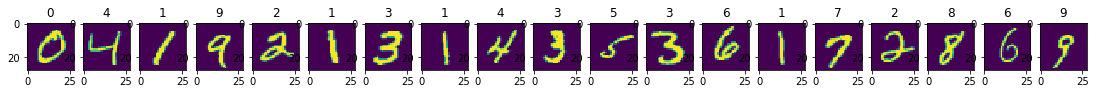

In [12]:
# For displaying the images
import torch
from torchvision import transforms
import torchvision.datasets as datasets

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True,
                                transform=transforms.Compose([transforms.ToTensor()]))

print(type(mnist_trainset))

# Show some of the images/data
number_to_print = 20
fig=plt.figure(figsize=(20, 12))

for i in range(1, number_to_print):
    
    img = transforms.ToPILImage(mode='L')(mnist_trainset[i][0])
    fig.add_subplot(1, number_to_print, i)
    plt.title(mnist_trainset[i][1])
    plt.imshow(img)
    
plt.show()

They appear to be simpler than the traffic light examples, so do we still need to use grayscale versions of them ?

In [13]:
# Number of examples
n_train = len(X_train)
n_test = len(X_test)

# Shape of an traffic sign image
image_shape = X_train.shape[1]
print(X_train.shape)

# unique classes/labels in the training dataset.
alltotal = set(y_train)
total_num_classes = len(alltotal)

print("Number of Training examples =", n_train)
print("Number of Test examples =", n_test)
print("Image input shape =", image_shape)
print("Total number of classes =", total_num_classes)
print("Test data shape {}".format(X_test.shape[1]))

(60000, 784)
Number of Training examples = 60000
Number of Test examples = 10000
Image input shape = 784
Total number of classes = 10
Test data shape 784


### Class Distribution:

Each 'class' represents a different digit and there are 10 different types in the dataset (0 -> 9)

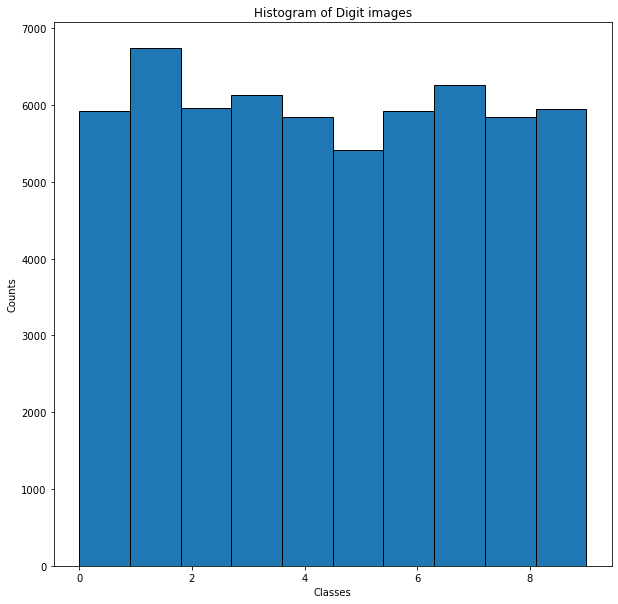

In [14]:
plot_distribution(y_train, total_num_classes)

## Downsampling

### Randomly selecting 3 of the 10 Digit Classes

In [15]:

# Empty list to append the random digit classes we select:
classes = []

# We select 'num_classes_to_use' digits at random and make sure they are unique:
while len(classes) < num_classes_to_use:
    
    # Randomly drawing a digit from 0-9:
    num2choose = np.random.randint(0,10)    

    # Append the digit if it's not already in our list of classes:    
    if num2choose not in classes:        
        classes.append(num2choose)
        
print("Unorted classes {}".format(classes))

# Sorting the Classes smallest to largest    
classes.sort()

# print classes selected
print("Sorted classes {}".format(classes))

Unorted classes [2, 6, 1]
Sorted classes [1, 2, 6]


The numpy `where(condition[, x, y])` method will return values from x or y depending on condition, so for below where r is in the training set, use [0], otherwise use the whole list.

In [16]:

inputs = []
labels = []

# Loop to randomly sample the instances for each digit:
for r in classes:

    imgs = X_train[np.where(y_train==r)[0], :]
    print("Using class {}, curr image shape {}".format(r, imgs.shape))
    inputs.append(imgs[np.random.permutation(imgs.shape[0]),:][0:num_class_instances,:])
    labels.append(np.ones(num_class_instances)*r)
    
# Shaping inputs and labels in the right format. vstack, alters the contents to be vertical
# So from ([1, 2, 3])
#    to array([[1],
#              [2],
#              [3]])
X_train = np.vstack(inputs).astype(np.float64)
y_train = np.hstack(labels)
print("Xtrain type is now {}".format(type(X_train)))

#------------------------- 
# The imgs has a shape of 784
#plt.figure(figsize=(8,8))
#print(imgs)

# Plotting 'original' image
#plot_digits(imgs,images_per_row=9) # images_per_row was set to 9
#plt.title("Original", fontsize=14)

Using class 1, curr image shape (6742, 784)
Using class 2, curr image shape (5958, 784)
Using class 6, curr image shape (5918, 784)
Xtrain type is now <class 'numpy.ndarray'>


In [17]:
print(inputs)

print(X_train, y_train)
print(X_train.shape)
print(y_train.shape)

[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [1. 1. 1. ... 6. 6. 6.]
(15000, 784)
(15000,)


#### Show the distribution with the new selected classes

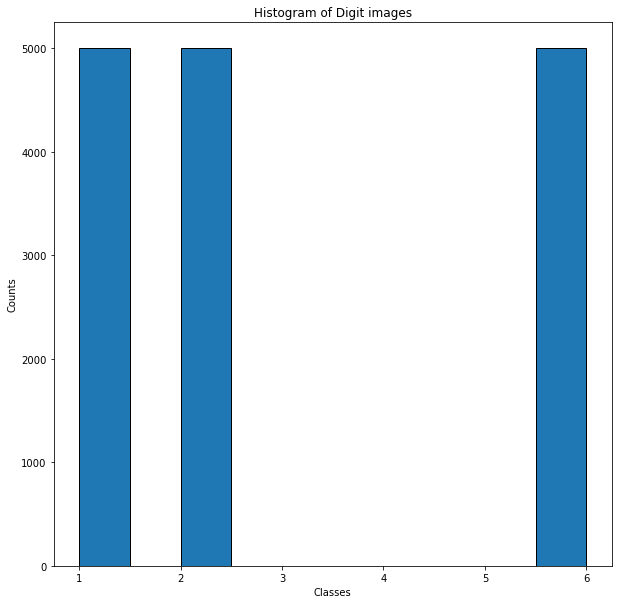

In [18]:
plot_distribution(y_train, num_classes_to_use)

The plot function is using 28x28 which is means 784 is required as the size of the array.<br><br>
Below we are plotting a random sample of 100 from the list of chosen classes to get an idea of what type of handwritten digits we are dealing with.

Text(0.5, 1.0, 'Original')

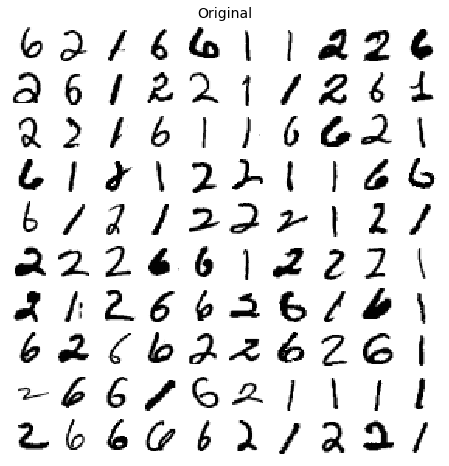

In [19]:
# Show a few instances from each Digit:
plt.figure(figsize=(8,8))

# Selecting a few label indices at random from each of the 3 classes to show:
label_indices = random.sample(range(0, len(X_train)), 100)

# Plotting 'original' image
plot_digits(X_train[label_indices,:],images_per_row=10)
plt.title("Original", fontsize=14)

###  Splitting the Training data into both Training and Validation Sets:

- Although this is the Training set, we can still set aside some samples (for instance 20%) of the 1,500 instances we have for Model Validation purposes.


- With that Validation Set, we can then select the amount of Uncertainty we are happy with from our Model to use out of sample on other unseen data.


- We can then test out how well our decision performs on the Test Set that we put aside earlier.

In [20]:
### Split tha dataset in training and validation sets
# choose the fraction of your validation data from the training set
w = 0.20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=w, random_state=0)
 
# Shuffling the training instaces around to randomize the order of inputs to the model:
X_train_shuf, y_train_shuf = shuffle(X_train, y_train)

### Print shape of your validation and training set

In [21]:
print("X training data shape {}".format(X_train.shape))
print("X validation set hape {}".format(X_val.shape))
print("Y training data shape {}".format(y_train.shape))
print("Y validation data shape {}".format(y_val.shape))

X training data shape (12000, 784)
X validation set hape (3000, 784)
Y training data shape (12000,)
Y validation data shape (3000,)


### Encoding the Class labels for the Probabilistic ML Model:

This is an example:

- **[1,0,0]** for first digit
- **[0,1,0]** for second digit
- **[0,0,1]** for third digit

### General-Recipe ML
* Using an integer for `random_state` will produce the same results each time
* `max_iter` - max number of iterations
* `C` 
* `solver` is the optimisation algorithm to use
* `multi_class` if you are using more than 2 classes

In [22]:
# General-recipe ML Multinomial logistic regression
gen_model_log = LogisticRegression(random_state=0,
                         max_iter=2000,
                         C=100,
                         solver='lbfgs',
                         multi_class='multinomial').fit(X_train_shuf, y_train_shuf)

# Classification:
y_pred_logi = gen_model_log.predict(X_val)
y_pred_logi_prob = gen_model_log.predict_proba(X_val)

prob_classmax = np.max(y_pred_logi_prob, axis=1)

# Computing the Accuracy:
print("Accuracy=", accuracy_score(y_pred_logi, y_val))

Accuracy= 0.974


Change 1 input to see is the accuracy improves - a 25 fold increase in iterations.

In [23]:
# General-recipe ML Multinomial logistic regression
gen_model_log_10 = LogisticRegression(random_state=0,
                         max_iter=50000,
                         C=100,
                         solver='lbfgs',
                         multi_class='multinomial').fit(X_train_shuf, y_train_shuf)

# Classification:
y_pred_logi_10 = gen_model_log_10.predict(X_val)
y_pred_logi_prob_10 = gen_model_log_10.predict_proba(X_val)

prob_classmax_10 = np.max(y_pred_logi_prob_10, axis=1)

# Computing the Accuracy:
print("Accuracy=", accuracy_score(y_pred_logi_10, y_val))

Accuracy= 0.974


Both results are the same, so no increase in accuracy would suggest other paramaters/inputs will need to change if I want to see greater accuracy.<br>
* When I set the number of instances to use from each class to 1000 and the number of postier samples was 300, the accuracy was 0.9633333333333334. It took 8 min 4 sec to execute.
* When I set the number of instances to use from each class to 2000 and the number of postier samples was 300, the accuracy was 0.975. It took 12 min and 38 seconds to run.
* When I set the number of instances to use from each class to 2000 and the number of postier samples was 1000, the accuracy was 0.975. It took 1hr 16 min to run.
* When I set the number of instances to use from each class to 5000 and the number of postier samples was 500 the accuracy was 0.974. It took 59 min and 12 seconds to run.

In [24]:
np.sort(prob_classmax)

array([0.4277706 , 0.51296928, 0.51767409, ..., 1.        , 1.        ,
       1.        ])

#### Print out some information on the incorrect results selected<br>
The shape is the number of wrong instances.

In [25]:
# probability of general-recipe logistic regression in wrong instances
prob_classmax[y_pred_logi!=y_val]
prob_classmax[y_pred_logi!=y_val].shape

(78,)

In [26]:
np.array(y_pred_logi)

array([1., 6., 6., ..., 6., 2., 1.])

#### Display a confusion matrix
This summarises the performance of the algorithm by displaying the results in table format - 

Text(0.5, 69.0, 'Predicted Label')

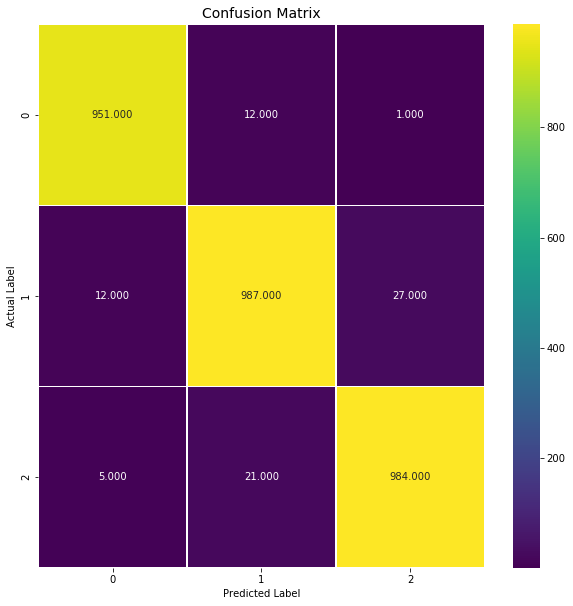

In [27]:
plt.figure(figsize=(10,10))
plt.title('Confusion Matrix', fontsize=14)
cm = metrics.confusion_matrix(y_val, y_pred_logi)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.6, cmap = 'viridis')

plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

#### Print some information on model performance

In [28]:
y_true = y_val
y_pred = y_pred_logi

target_names_lst = []

for digit in classes:
  target_names_lst.append("Digit/class {}".format(digit))

print(classification_report(y_true, y_pred, target_names=target_names_lst, digits=4))

               precision    recall  f1-score   support

Digit/class 1     0.9824    0.9865    0.9845       964
Digit/class 2     0.9676    0.9620    0.9648      1026
Digit/class 6     0.9723    0.9743    0.9733      1010

     accuracy                         0.9740      3000
    macro avg     0.9741    0.9743    0.9742      3000
 weighted avg     0.9740    0.9740    0.9740      3000



### Probabilistic Multinomial Logistic Regression:

The Multinomial Logistic Regression has some parameters:

- $\alpha$, which is the intercept term:

- $\beta$, which is a vector of coefficients which give a weighting to the importance of each input feature:

Using PyMC3 to build a model.

In [29]:
# We use LabelBinarizer to transfor classes into counts
# neg_label=0, pos_label=1

y_2_bin = sklearn.preprocessing.LabelBinarizer().fit_transform(y_train_shuf.reshape(-1,1))
x_train_shape = X_train_shuf.shape[1]
print("Shuffle X_train shape {}".format(x_train_shape))

# number of classes
num_classes = len(classes)
print("Number of classes {}".format(num_classes))

# floatX = float32
floatX = tt.config.floatX

init_b = np.random.randn(x_train_shape, num_classes - 1).astype(floatX)
init_a = np.random.randn(num_classes - 1).astype(floatX)


with pm.Model() as bay_multi_logistic:
    
    # Prior
    β = pm.Normal('beta', 0, sigma=100, shape=(x_train_shape, num_classes-1), testval=init_b)
    α = pm.Normal('alpha', 0, sigma=100, shape=(num_classes - 1,), testval=init_a)
    
    # we need to consider nc-1 features because the model is not identifiable
    # the softmax turns a vector into a probability that sums up to one
    # therefore we add zeros to go back to dimension nc
    # so that softmax returns a vector of dimension nc
    β1  = tt.tensor.concatenate([np.zeros((x_train_shape, 1)),β ],axis=1)
    α1  = tt.tensor.concatenate([[0],α ],)
    
    # Likelihood
    mu = pm.math.matrix_dot(X_train_shuf, β1) + α1
    
    # It doesn't work if the problem is binary
    p = tt.tensor.nnet.nnet.softmax(mu)
    observed = pm.Multinomial('likelihood', p=p, n=1, observed=y_2_bin)


Shuffle X_train shape 784
Number of classes 3


In [30]:
print(y_2_bin)

[[0 0 1]
 [0 0 1]
 [0 0 1]
 ...
 [0 0 1]
 [1 0 0]
 [0 0 1]]


#### Test with different number of itterations
https://docs.pymc.io/notebooks/variational_api_quickstart.html
    
* `advi` is automatic differentiation variational inference. This automatically derives an efficient variational inference algorithm (https://en.wikipedia.org/wiki/Variational_Bayesian_methods)
* Testing with smaller number of iterations when `num_class_instances` was increased to a 4 digit number

In [31]:
#with bay_multi_logistic:
#    approx3k = pm.fit(3000, method='advi')

#plt.figure(figsize=(10,8))
#plt.plot(approx3k.hist)

In [32]:
#with bay_multi_logistic:
#    approx5k = pm.fit(5000, method='advi')
    
#plt.figure(figsize=(10,8))
#plt.plot(approx5k.hist)

Finished [100%]: Average Loss = 9,096.2


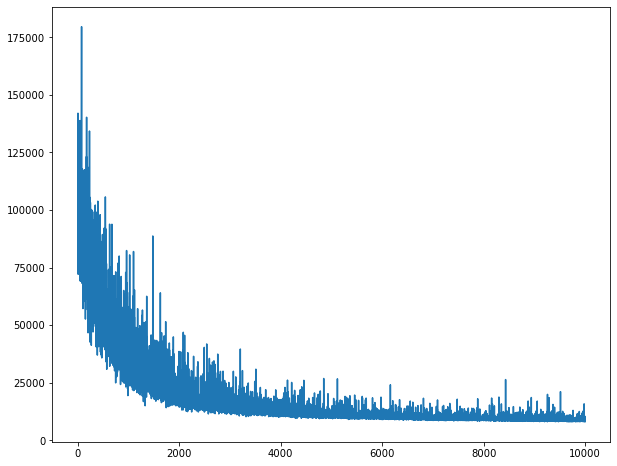

In [33]:
with bay_multi_logistic:
    approx10k = pm.fit(10000, method='advi')
    
plt.figure(figsize=(10,8))
plt.plot(approx10k.hist)

The next 2 cells will take some time to execute, so leave out for now.

In [34]:
#with bay_multi_logistic:
#    approx30k = pm.fit(30000, method='advi')

#plt.plot(approx30k.hist)

In [35]:
# Takes over 30 minutes. Might execute at the end for comparison.
#with bay_multi_logistic:
#    approx100k = pm.fit(100000, method='advi')

#plt.plot(approx100k.hist)

#### Get samples from the posterior set using the given step methods.
* From https://docs.pymc.io/api/inference.html

In [36]:

posterior = approx10k.sample(draws=num_of_posterior_samples)

#### Test some images
Applying softmax will ensure that each value will be between 0 and 1, and they will add up to 1, so that they can be interpreted as probabilities.

Test image #257
Posterior sample #196
True class= 6.0
classes: [1, 2, 6]
The estimated prob= [0. 0. 1.]


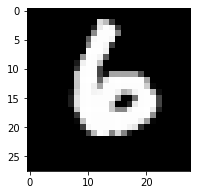

In [37]:
## The softmax function transforms each element of a collection by computing the exponential
#  of each element divided by the sum of the exponentials of all the elements.

# Select an image in the test set
test_img_indx = random.randint(0, num_of_posterior_samples)

# Select a sample in the posterior
posterier_sample = random.randint(0, num_of_posterior_samples)

beta  = np.hstack([np.zeros((x_train_shape, 1)),  posterior['beta'][posterier_sample,:] ])
alpha = np.hstack([[0], posterior['alpha'][posterier_sample,:] ])
image = X_val[test_img_indx,:].reshape(image_dimension, image_dimension)

plt.figure(figsize=(3,3))
plt.imshow(image, cmap="Greys_r")
np.set_printoptions(suppress=True)

print("Test image #" + str(test_img_indx))
print("Posterior sample #" + str(posterier_sample))
print("True class=", y_val[test_img_indx])
print("classes: " + str(classes))
print("The estimated prob=",softmax((np.array([X_val[test_img_indx,:].dot(beta) + alpha])))[0,:])

Test image #119
Posterior sample #400
True class= 2.0
classes: [1, 2, 6]
The estimated prob= [0.        0.9997372 0.0002628]


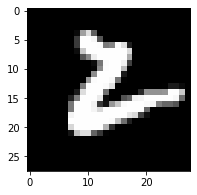

In [38]:
test_img_indx = random.randint(0, num_of_posterior_samples)
posterier_sample = random.randint(0, num_of_posterior_samples)

beta  = np.hstack([np.zeros((x_train_shape, 1)),  posterior['beta'][posterier_sample,:] ])
alpha = np.hstack([[0],  posterior['alpha'][posterier_sample,:] ])
image = X_val[test_img_indx,:].reshape(image_dimension, image_dimension)

plt.figure(figsize=(3,3))
plt.imshow(image, cmap="Greys_r")
np.set_printoptions(suppress=True)

print("Test image #" + str(test_img_indx))
print("Posterior sample #" + str(posterier_sample))
print("True class=", y_val[test_img_indx])
print("classes: " + str(classes))
print("The estimated prob=",softmax((np.array([X_val[test_img_indx,:].dot(beta) + alpha])))[0,:])

Depending on the digits chosen, on some executions, both digits were correctly classified but on some they were not.

#### Calculate the bayesian prediction

In [39]:
print("Start time {}".format(datetime.datetime.now().time()))
calc_y_pred_bayesian = calc_bay_pred(X_val, classes, x_train_shape, posterior)
print("Finish time {}".format(datetime.datetime.now().time()))

Start time 19:03:08.969278
Finish time 19:23:59.380179


In [40]:
print(calc_y_pred_bayesian)
print(len(calc_y_pred_bayesian))

[0, 2, 2, 0, 1, 0, 2, 2, 1, 0, 1, 1, 0, 2, 0, 2, 0, 2, 2, 1, 2, 1, 1, 0, 0, 0, 2, 1, 1, 1, 1, 2, 1, 0, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 1, 0, 1, 0, 0, 0, 2, 1, 2, 2, 1, 1, 0, 2, 1, 1, 1, 0, 2, 0, 1, 0, 2, 2, 1, 2, 1, 2, 2, 0, 0, 1, 2, 2, 2, 2, 1, 0, 0, 0, 0, 1, 2, 0, 2, 2, 0, 1, 1, 0, 1, 2, 2, 1, 0, 2, 2, 0, 2, 2, 1, 1, 1, 0, 2, 0, 1, 1, 2, 1, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 1, 2, 0, 1, 0, 1, 2, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 0, 1, 0, 1, 2, 0, 0, 0, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 0, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 1, 0, 0, 0, 2, 1, 1, 2, 1, 1, 2, 0, 2, 0, 2, 1, 2, 2, 0, 1, 0, 0, 2, 0, 1, 0, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 1, 2, 1, 0, 2, 0, 0, 2, 1, 2, 1, 2, 2, 2, 2, 0, 1, 0, 0, 0, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 0, 1, 2, 1, 1, 1, 0, 1, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 1, 1, 0, 2, 0, 2, 1, 1, 0, 0, 1, 2, 0, 0, 1, 1, 1, 1, 0, 0, 2, 1, 1, 1, 2, 1, 0, 0, 0, 2, 0, 2, 2, 2, 0, 1, 0, 0, 1, 1, 2, 0, 2, 1, 2, 1, 1, 2, 1, 2, 2, 

In [41]:
 # prediction array (using classes)
np.array(classes)[calc_y_pred_bayesian[0:100]]

array([1, 6, 6, 1, 2, 1, 6, 6, 2, 1, 2, 2, 1, 6, 1, 6, 1, 6, 6, 2, 6, 2,
       2, 1, 1, 1, 6, 2, 2, 2, 2, 6, 2, 1, 6, 2, 6, 2, 6, 2, 6, 2, 6, 6,
       1, 6, 2, 6, 6, 6, 6, 6, 2, 1, 2, 1, 1, 1, 6, 2, 6, 6, 2, 2, 1, 6,
       2, 2, 2, 1, 6, 1, 2, 1, 6, 6, 2, 6, 2, 6, 6, 1, 1, 2, 6, 6, 6, 6,
       2, 1, 1, 1, 1, 2, 6, 1, 6, 6, 1, 2])

In [42]:
print("Accuracy =", accuracy_score(np.array(classes)[calc_y_pred_bayesian], y_val))

Accuracy = 0.9783333333333334


In [43]:
# recall the classes we are using
print(classes)

[1, 2, 6]


The code below is printing the number of each of the digits(classes) selected. I notice that the first class chosen, always seems to have a slightly higher count than the others (~10%).

In [44]:
print(Counter(calc_y_pred_bayesian))

Counter({2: 1021, 1: 1013, 0: 966})


### 3 - Use the posterior uncertainty to detect the instances (digits) in the test set that are hard to classify and remove them from the test-set.

In [45]:
print("Start time {}".format(datetime.datetime.now().time()))

y_predB=[]

for i in range(X_val.shape[0]):
    val=[]

    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((x_train_shape,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
        val.append(softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

    # mean probability
    valmean = np.mean(val,axis=0)
    
    # class with maximum mean probability
    classmax = np.argmax(valmean)
    
    # ranks
    ranks = np.array(val.copy())
    ranks   = ranks  *0 #init
    colmax = np.argmax(np.array(val),axis=1)
    ranks[np.arange(0,len(colmax)),colmax]=1
     
    y_predB.append( [classmax, valmean[classmax], np.std(ranks,axis=0)[classmax]])

print("Finish time {}".format(datetime.datetime.now().time()))

y_predB = np.array(y_predB)

Start time 19:23:59.426568
Finish time 19:45:12.289012


In [46]:
# prediction array
mm = 10
y_predB[0:mm,:]

array([[0.        , 0.99198689, 0.06311894],
       [2.        , 0.98415535, 0.11749043],
       [2.        , 0.95854113, 0.1862901 ],
       [0.        , 0.9944612 , 0.04467662],
       [1.        , 0.99999999, 0.        ],
       [0.        , 0.99913316, 0.        ],
       [2.        , 0.99999717, 0.        ],
       [2.        , 0.99879809, 0.        ],
       [1.        , 0.99747873, 0.04467662],
       [0.        , 0.99378648, 0.04467662]])

In [47]:
# sorting in descending order

difficult = np.argsort(-y_predB[:,2])
y_predB[difficult[0:mm],:]

array([[0.        , 0.48490661, 0.5       ],
       [1.        , 0.50095917, 0.499996  ],
       [2.        , 0.49339806, 0.499984  ],
       [1.        , 0.50321063, 0.499984  ],
       [0.        , 0.50907031, 0.49980396],
       [2.        , 0.52378108, 0.49959984],
       [1.        , 0.4639985 , 0.49942367],
       [0.        , 0.46780317, 0.49932354],
       [2.        , 0.52652362, 0.49932354],
       [1.        , 0.48051853, 0.49932354]])

In [48]:
# Probability of general-recipe logistic regression in wrong instances

prob_classmax[y_pred_logi != y_val]

array([1.        , 0.99999079, 0.99995903, 0.99981374, 0.98076829,
       0.93137645, 0.87113498, 0.97080221, 0.99999997, 0.51296928,
       0.92680352, 0.99915789, 0.68432783, 0.99888195, 1.        ,
       0.58903824, 0.93710512, 0.99980622, 0.92446325, 0.86397067,
       0.99999999, 0.75025176, 0.99999971, 0.9994692 , 0.9999984 ,
       0.98467687, 0.99772768, 0.99996546, 0.99977228, 0.89004746,
       0.85516817, 0.74951829, 0.96668988, 0.9765551 , 0.6724703 ,
       0.63619935, 0.95333015, 0.96544608, 0.96015209, 1.        ,
       0.99699994, 0.99951683, 0.97156442, 0.63327509, 0.99833054,
       0.98800443, 0.95570361, 0.9779043 , 0.68061144, 0.9995376 ,
       0.93556013, 0.99999203, 0.99912004, 0.52556386, 0.99511314,
       0.99999959, 1.        , 0.96197693, 0.8952917 , 0.86472182,
       0.99530662, 0.60180719, 0.67798989, 0.9999999 , 0.98787313,
       1.        , 0.4277706 , 0.97469836, 0.99838925, 0.95933341,
       0.9994429 , 0.99567736, 0.66592995, 0.67156939, 0.97809

In [49]:
y_predB[y_pred_logi != y_val,:]

array([[1.        , 0.99898056, 0.        ],
       [2.        , 0.73134479, 0.43863424],
       [1.        , 0.74645789, 0.42949272],
       ...,
       [1.        , 0.97934366, 0.1254751 ],
       [1.        , 0.50321063, 0.499984  ],
       [2.        , 0.97223934, 0.10888526]])

 Calculate the difficult & easy accuracy for comparison.

In [50]:

easy = np.argsort(y_predB[:,2])
print("Accuracy in easy instances =", accuracy_score(y_pred_logi[easy[0:100]],
                                                     y_val[easy[0:100]]))

difficult = np.argsort(-y_predB[:,2])
print("Accuracy in difficult instances =", accuracy_score(y_pred_logi[difficult[0:100]],
                                                          y_val[difficult[0:100]]))

Accuracy in easy instances = 1.0
Accuracy in difficult instances = 0.69


Show a sample of 20 images from the easy list in colour and grayscale and grayscale for comparison.

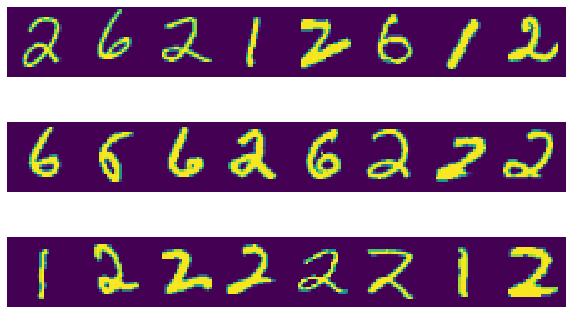

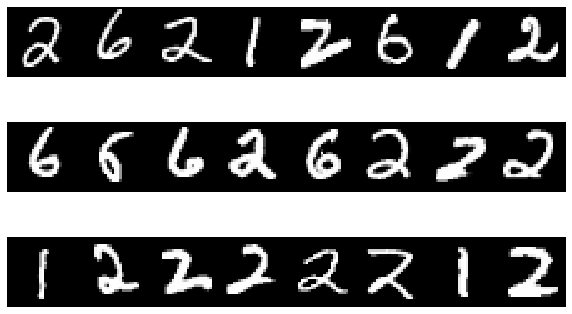

In [51]:
show_images(easy, X_val, 20)
show_images(easy, X_val, 20, image_dimension, True)

Show a sample of 20 images from the difficult list in colour and grayscale for comparison.

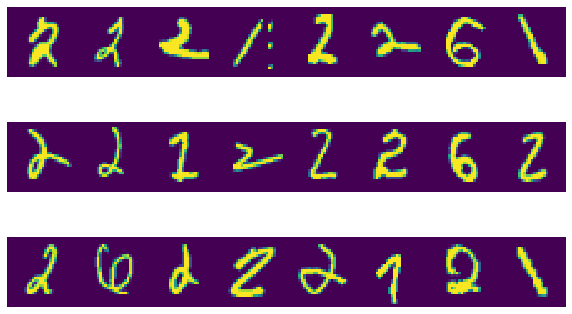

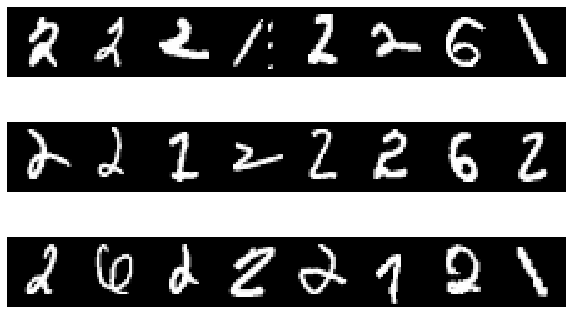

In [52]:

show_images(difficult, X_val, 20)
show_images(difficult, X_val, 20, image_dimension, True)

### 4 - Compute again the accuracy of the general-recipe logistic regression on the remaining (non-difficult) instances and comment on the result.
Re-run of multinomial logistic regression without difficult samples

In [53]:

easy_model_log = LogisticRegression(random_state=0,
                               max_iter=2000,
                               C=100,
                               solver='lbfgs',
                               multi_class='multinomial').fit(X_train_shuf[easy],
                                                              y_train_shuf[easy])

# Classification:
y_pred_log_easy = easy_model_log.predict(X_val)
y_pred_logi_prob_easy = easy_model_log.predict_proba(X_val)

# Maybe taking the maximum probability 
# in any of the classes for each observation
prob_classmax_easy = np.max(y_pred_logi_prob_easy, axis=1)

# Computing the Accuracy:
accuracy_score(y_pred_log_easy, y_val)

print("Original Model Accuracy {}".format(accuracy_score(y_pred_logi, y_val)))
print("Number of misclassifications {}".format(len(prob_classmax[y_pred_logi!=y_val])))

# Retrained
print("Retrained Model Accuracy: {}".format(accuracy_score(y_pred_log_easy, y_val)))
print("Number of misclassifications {}".format(len(prob_classmax_easy[y_pred_log_easy!=y_val])))

Original Model Accuracy 0.974
Number of misclassifications 78
Retrained Model Accuracy: 0.9753333333333334
Number of misclassifications 74


TBC...

In [54]:
print("Etivity-1 completion time {}".format(datetime.datetime.now().time()))

Etivity-1 completion time 19:45:17.838520


## Summary

#### Basic understanding
As I understand it, the etivity ask is to use posterior probability (Bayes - which is an adjustment on prior probability) which is the probability of an outcome given we have new information, to be able classify multiple types of events (not just true/false, events being hand written digits in this case) for the MNIST dataset and it is multinomial because the dataset is a set of handwritten digits from 0 - 9 and not just a set of 2 digits.<br><br>
Not surprisingly, the 2 variables that had the greatest impact in execution time were the number of samples used from the posterior list and the number of digit/class instances that were used. The details of the times are in the 'General-Recipe ML' markdown cell above. Increasing the number of class instances had a much larger effect on the execution time and there was no major increase in the reported accuracy with the much larger class instance size.

#### Peer discussion
I found the questions and answers in group forums on the use of the other performance statistics (confusion matrix, F1 score etc) and softmax function and the code around it to be very helpful in trying to understand its use and I have added those stats to this notebook.

## References
These references are a combination of my own search and from posts by others.

### Websites
#### https://en.wikipedia.org/wiki/Maximum_likelihood_estimation
#### https://en.wikipedia.org/wiki/Posterior_probability
#### https://towardsdatascience.com/probability-concepts-explained-maximum-likelihood-estimation-c7b4342fdbb1
#### https://towardsdatascience.com/a-gentle-introduction-to-maximum-likelihood-estimation-9fbff27ea12f
#### https://towardsdatascience.com/introduction-to-bayesian-logistic-regression-7e39a0bae691
#### https://statquest.org/
#### http://docs.zeligproject.org/articles/zelig_mlogitbayes.html
#### https://pandas.pydata.org/docs/reference/api/pandas.read_pickle.html
#### https://www.statisticshowto.com/
#### https://www.mathsisfun.com/sets/symbols.html
#### https://docs.pymc.io/
#### https://machinelearningmastery.com/softmax-activation-function-with-python/

### Books/Papers
#### Salvatier J., Wiecki T.V., Fonnesbeck C. (2016) Probabilistic programming in Python using PyMC3. PeerJ Computer Science 2:e55 DOI: 10.7717/peerj-cs.55.
#### Statistics by David W.H. Swenson - http://www.cchem.berkeley.edu/chem120a/extra/statistics.pdf
#### Automatic Differentiation Variational Inference https://arxiv.org/pdf/1603.00788.pdf